In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_excel('assets/CBI_AI-100_reportlist.xlsx')
df.reset_index(drop = True, inplace = True)
df.columns = [x.lower() for x in df.loc[1, :]]
df = df.loc[2:, :]
df.reset_index(drop = True, inplace = True)
print(len(df))

df.head()

100


,company,sector,focus area,total disclosed funding ($m),country,select investors
0,4Paradigm,Finance & Insurance,Anti-Fraud,145,China,"Agricultural Bank of China, Bank of China, Chi..."
1,ABEJA,Retail,Analytics,45.4,Japan,"Google, Mitsubishi UFJ Capital, Mizuho Capital..."
2,AEye,Auto,Perception,61.62,United States,"Airbus Ventures, Intel Capital, Kleiner Perkin..."
3,Agari Data,Enterprise Tech,Cybersecurity,86.5,United States,"Battery Ventures, First Round Capital, Goldman..."
4,AI Foundation,Media,Fake News Detection,10,United States,"Biz Stone, Endeavor, Founders Fund, You & Mr J..."


In [3]:
df['sector'].value_counts()

Enterprise Tech            33
Healthcare                 14
Auto                       11
Semiconductor               7
Industrials                 6
Government                  6
Retail                      5
Legal, Compliance, & HR     4
Finance & Insurance         4
Media                       3
Finance & Insurance         2
Agriculture                 2
Real estate                 2
Telecom                     1
Name: sector, dtype: int64

In [4]:
df['total disclosed\nfunding ($m)'] = [float(x) for x in df['total disclosed\nfunding ($m)']]
df['total disclosed\nfunding ($m)'].describe()

count      98.000000
mean      102.915408
std       195.361886
min         4.000000
25%        25.212500
50%        47.745000
75%        91.100000
max      1630.000000
Name: total disclosed\nfunding ($m), dtype: float64

In [5]:
df['country'].value_counts()

United States     77
China              6
United Kingdom     6
Israel             6
Germany            1
Japan              1
Sweden             1
Canada             1
India              1
Name: country, dtype: int64

In [6]:
df['is_US'] = [1 if x == 'United States' else 0 for x in df['country']]
df['is_US'].value_counts()

1    77
0    23
Name: is_US, dtype: int64

In [7]:
df['select investors'] = [x.split(', ') if type(x) == str else x for x in df['select investors']]
investors = []
for i in list(df.index):
    listy = [x.strip() for x in df.loc[i, 'select investors']]
    investors.append(listy)
df['select investors'] = investors

all_investors = []
for i in list(df.index):
    investors = df.loc[i, 'select investors']
    all_investors.extend(investors)
    
all_investors = pd.DataFrame(all_investors)
print(len(all_investors))
all_investors.columns = ['count']
all_investors = pd.DataFrame(all_investors['count'].value_counts())
# all_investors = all_investors[all_investors['count'] > 1]
print(len(all_investors))

432
272


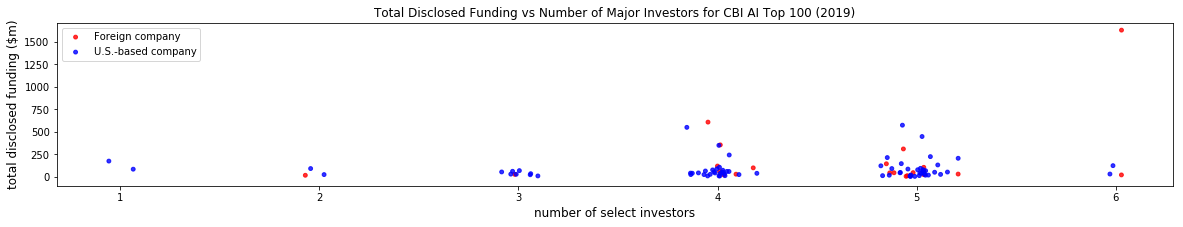

In [8]:
df['investor count'] = [len(x) for x in df['select investors']]
df['color'] = ['blue' if x == 'United States' else 'red' for x in df['country']]

def rand_jitter(arr):
    stdev = .015*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

plt.figure(figsize = (20, 3))
plt.title('Total Disclosed Funding vs Number of Major Investors for CBI AI Top 100 (2019)')
for which in list(set(df['is_US'])):
    lil_df = df[df['is_US'] == which]
    if which == 1:
        name = 'U.S.-based company'
    else:
        name = 'Foreign company'
    plt.scatter(
        rand_jitter(lil_df['investor count']), 
        lil_df['total disclosed\nfunding ($m)'], 
        color = lil_df['color'], 
        s = 15, 
        alpha = 0.8,
        label = name
    )
plt.xlabel('number of select investors', fontsize = 12)
plt.ylabel('total disclosed funding ($m)', fontsize = 12)
plt.legend()
plt.show();

In [9]:
sectors = list(set(df['sector']))
sectors = [x for x in sectors]
new_sectors = []
for sector in sectors:
    lil_df = df[df['sector'] == sector]
    colname = sector.replace('\xa0', ' ') 
    new_sectors.append(colname)
    col = []
    for investor in list(all_investors.index):
        count = 0
        for startup in lil_df['company']:
            liller_df = lil_df[lil_df['company'] == startup]
            if investor in liller_df['select investors'].values[0]:
                count += 1
        col.append(count)
    all_investors[colname] = col

In [10]:
all_investors.sum()

count                      432
Enterprise Tech            146
Healthcare                  59
Telecom                      4
Finance & Insurance         10
Agriculture                  9
Retail                      24
Legal, Compliance, & HR     17
Real estate                  8
Media                       14
Government                  27
Auto                        48
Industrials                 23
Semiconductor               26
dtype: int64

In [11]:
all_investors.sum().sort_values()

Telecom                      4
Real estate                  8
Agriculture                  9
Finance & Insurance         10
Media                       14
Legal, Compliance, & HR     17
Industrials                 23
Retail                      24
Semiconductor               26
Government                  27
Auto                        48
Healthcare                  59
Enterprise Tech            146
count                      432
dtype: int64

In [12]:
all_investors = all_investors[list(all_investors.drop('count', axis = 1).sum().sort_values().index[::-1])]
all_investors.sum()

Enterprise Tech            146
Healthcare                  59
Auto                        48
Government                  27
Semiconductor               26
Retail                      24
Industrials                 23
Legal, Compliance, & HR     17
Media                       14
Finance & Insurance         10
Agriculture                  9
Real estate                  8
Telecom                      4
dtype: int64

In [13]:
countries = list(set(df['country']))
country_dict = {}
for investor in list(all_investors.index):
    country_dict.update({investor : []})
    
for country in countries:
    if country == 'United States':
        pass
    else:
        lil_df = df[df['country'] == country]
        for investor in list(all_investors.index):
            for startup in lil_df['company']:
                liller_df = lil_df[lil_df['company'] == startup]
                if investor in liller_df['select investors'].values[0]:
                    country_dict[investor] = country_dict[investor] + [country]

In [14]:
investor_labels = []
for investor in list(all_investors.index):
    if len(list(country_dict[investor])) > 0:
        listy = ''
        for which in sorted(list(set(country_dict[investor]))):
            listy += which + ', '
        listy = listy[:-2]
        name = investor + ' (incl {})'.format(listy)
        investor_labels.append(name)
    else:
        investor_labels.append(investor)

In [28]:
all_investors['count'] = all_investors.sum(axis = 1).values
all_investors['count'].value_counts()

/Users/Rebecca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


2     33
3     10
5      9
4      6
6      2
14     1
10     1
9      1
7      1
Name: count, dtype: int64

In [30]:
all_investors = all_investors[all_investors['count'] > 1]
all_investors.sort_values('count', ascending = False, inplace = True)
all_investors.drop('count', axis = 1, inplace = True)

13


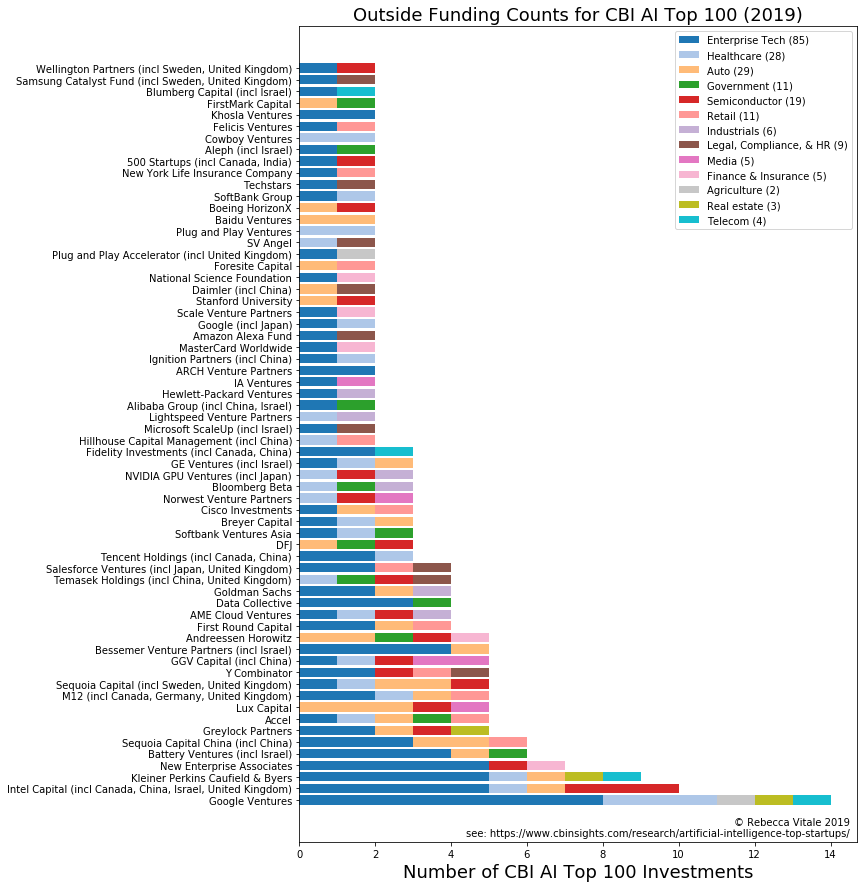

In [32]:
fig, ax = plt.subplots(figsize = (10, 15))
ax.set_title('Outside Funding Counts for CBI AI Top 100 (2019)', fontsize = 18)

ind = range(len(all_investors))
left = np.zeros(len(list(all_investors.index)))
cm = plt.get_cmap('tab20')
NUM_COLORS = len(all_investors.columns)
print(NUM_COLORS)
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for sector in list(all_investors.columns):
    bt = plt.barh(
        ind, 
        all_investors[sector], 
        label = sector + ' (' + str(all_investors[sector].sum()) + ')',
        left = left
    )
    left += all_investors[sector]
    
ax.set(
    yticks = ind,
    yticklabels = investor_labels
)
plt.tick_params(axis = 'both', which = 'major', labelsize = 10)
plt.xlabel('Number of CBI AI Top 100 Investments', fontsize = 18)
plt.figtext(0.89, 0.13, 'see: https://www.cbinsights.com/research/artificial-intelligence-top-startups/', horizontalalignment = 'right')
plt.figtext(0.89, 0.14, '© Rebecca Vitale 2019', horizontalalignment = 'right')
plt.legend()
plt.show();